# Graph 

In [1]:
from __future__ import print_function
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; } </style>"))

In [2]:
from enum import Enum
class Scenario(Enum):
    single_object_single_robot = 0
    double_object_single_robot = 1
    single_object_dual_robot = 2
    assembly_3_piece = 3
    custom_robots = 4
    
current_scenario = Scenario.custom_robots

In [3]:
urdf_content = None
if current_scenario in [Scenario.single_object_dual_robot, Scenario.assembly_3_piece]:
    from pkg.ur10_dual import URDF_PATH, JOINT_NAMES, LINK_NAMES, ZERO_JOINT_POSE, get_collision_items_dict
elif current_scenario in [Scenario.single_object_single_robot, Scenario.double_object_single_robot]:
    from pkg.ur10 import URDF_PATH, JOINT_NAMES, LINK_NAMES, ZERO_JOINT_POSE, get_collision_items_dict
else:
    from pkg.robots_custom import *
    xcustom = XacroCustomizer()
    xcustom.clear()
    xcustom.add_robot(RobotType.indy7_robot, xyz=[0,-0.5,0], rpy= [0,0,0])
    xcustom.add_robot(RobotType.panda_robot, xyz=[0,0.5,0], rpy= [0,0,0])
    xcustom.write_xacro()
    vel_scale = 1.0/2.0
    JOINT_NAMES, LINK_NAMES, ZERO_JOINT_POSE, urdf_content = \
            xcustom.convert_xacro_to_urdf(
            joint_fix_dict={'finger':'upper'},
            vel_limit_dict={k: v*vel_scale for k,v in {
                'panda1_joint1': np.deg2rad(150),  'panda1_joint2': np.deg2rad(150), 
                'panda1_joint3': np.deg2rad(150), 'panda1_joint4': np.deg2rad(150), 
                'panda1_joint5': np.deg2rad(180), 'panda1_joint6': np.deg2rad(180), 'panda1_joint7': np.deg2rad(180), 
                'indy0_joint0': np.deg2rad(150), 'indy0_joint1': np.deg2rad(150), 'indy0_joint2': np.deg2rad(150), 
                'indy0_joint3': np.deg2rad(180), 'indy0_joint4': np.deg2rad(180), 'indy0_joint5': np.deg2rad(180), 
            }.items()}
        )
    ZERO_JOINT_POSE=np.array([0,0,-np.pi/2,0,-np.pi/2,0,
                              0,-np.pi/8,0,-np.pi/2,0,np.pi/2,0])
    refine_meshes()
    xcustom.start_rviz()
    
from pkg.constraint_graph import *
import matplotlib.pyplot as plt
from pkg.plot_utils import *
from pkg.utils import *
# from threading import Thread, Lock
from multiprocessing import Process, Lock, Manager
PROC_MODE = True
rospy.init_node('task_planner', anonymous=True)

Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran0']/actuator[@name='indy0_motor0']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran1']/actuator[@name='indy0_motor1']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran2']/actuator[@name='indy0_motor2']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran3']/actuator[@name='indy0_motor3']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran4']/actuator[@name='indy0_motor4']
Unknown tag "hardwareInterface" in /robot[@name='custom_robots']/transmission[@name='indy0_tran5']/actuator[@name='indy0_motor5']


In [4]:
gtimer = GlobalTimer.instance()
gtimer.reset()
graph = ConstraintGraph(urdf_path=URDF_PATH, joint_names=JOINT_NAMES, link_names=LINK_NAMES, urdf_content=urdf_content)
col_items_dict = graph.set_collision_items(
    get_collision_items_dict(graph.urdf_content, color=(0,1,0,0.5), display=True, collision=True, 
                             exclude_link=["panda1_link7"]))

# Custom Robots

In [5]:
gtimer.tic("set_scene")
if current_scenario == Scenario.custom_robots:
    collision=True
    graph.add_collision_items("world", 
                              [
                               GeoMesh(uri="package://my_mesh/meshes/stl/AirPick_cup_ctd.stl", BLH=(0.01,0.01,0.01), scale=(1e-3,1e-3,1e-3), name="gripper1", link_name="indy0_tcp", 
                                       urdf_content=graph.urdf_content, color=(0.1,0.1,0.1,1), collision=False),
                               GeoBox((0.5,-0.2,0.050), (0.05,0.05,0.05), name="box1", link_name="world", urdf_content=graph.urdf_content, color=(0.3,0.3,0.8,1), collision=collision),
                               GeoBox((0,0,-0.005), (3,3,0.01), name="floor", link_name="world", urdf_content=graph.urdf_content, color=(0.6,0.6,0.6,1), collision=collision),
                               GeoBox((0.7,0.0,0.2), (0.7,0.05,0.4), name="wall", link_name="world", urdf_content=graph.urdf_content, color=(0.4,0.3,0.0,1), collision=collision),
                               GeoBox((0.4,0.4,0.15), (0.15,0.15,0.3), name="stepper", link_name="world", urdf_content=graph.urdf_content, color=(0.4,0.3,0.0,1), collision=collision),
                               GeoBox((0.4,0.4,0.3), (0.1,0.1,1e-3), name="goal_disp", link_name="world", urdf_content=graph.urdf_content, color=(0.8,0.0,0.0,1), collision=False)])
    
    graph.register_binder(name='grip1', _type=VacuumTool, point=[0,-2.5e-2,11e-2], link_name="panda1_hand", direction=[0,1,0])
    graph.register_binder(name='vac2', _type=VacuumTool, point=[0,0,5e-2], link_name="indy0_tcp", direction=[0,0,1])
    graph.register_binder(name='floor', _type=PlacePlane, direction=[0,0,1])
    graph.register_binder(name='goal', _type=PlaceFrame, point=(0.4,0.4,0.3+5e-4), link_name="world", orientation=[0,0,0])

    graph.register_object('box1', _type=BoxAction, binding=("bottom_p","floor"), hexahedral=True)

    graph.build_graph()
gtimer.toc("set_scene")

# Set RVIZ

In [6]:
gtimer.tic("set_sim")
graph.set_simulation(nWSR=50, regularization_factor= 1e-1)
gtimer.toc("set_sim")
# graph.show_pose(ZERO_JOINT_POSE, execute=True)

Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker


# Search Graph (Custom Robots)

In [9]:
gtimer.reset()
if current_scenario == Scenario.custom_robots:
    graph.search_graph_mp(
        initial_state = State((('box1','bottom_p','floor'),),
                              {'box1': SE3(np.identity(3), [0.5,-0.3,0.05])}, ZERO_JOINT_POSE),
        goal_state = State((('box1','front_f','goal'),), None, None),
        tree_margin = 4, depth_margin = 2, joint_motion_num=10, 
        terminate_on_first = True, N_search = 100, N_loop=1000,
        display=False, dt_vis=1e-3, verbose = True, print_expression=False,
        **dict(N=300, dt=0.025, vel_conv=1e-2, err_conv=1e-3, N_step=300))


success - Goal cost:2->1 / Init cost:0->1 / branching: 0->1 (1.42 s)
node: (('box1', 'bottom_p', 'floor'),)->(('box1', 'top_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (2.64 s)
node: (('box1', 'bottom_p', 'floor'),)->(('box1', 'back_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (2.96 s)
node: (('box1', 'bottom_p', 'floor'),)->(('box1', 'front_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (3.41 s)
node: (('box1', 'bottom_p', 'floor'),)->(('box1', 'left_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (3.51 s)
node: (('box1', 'bottom_p', 'floor'),)->(('box1', 'left_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (3.65 s)
node: (('box1', 'bottom_p', 'floor'),)->(('box1', 'right_p', 'vac2'),)

fail - Goal cost:2->1 / Init cost:0->1 / branching: 0-> (3.76 s)
node: (('box1', 'bottom_p', 'floor'),)->(('box1', 'back_p', 'grip1'),)

fail - Goal cost:2->1 / Init cost:0->1 /

In [10]:
print(gtimer)

search_graph_mp: 	7383.0 ms/1 = 7382.851 ms 
init_search: 	3.0 ms/1 = 2.877 ms 
score_graph: 	1.0 ms/2 = 0.429 ms 
reset_valid_node: 	0.0 ms/233 = 0.002 ms 
get_valid_neighbor: 	1.0 ms/23 = 0.036 ms 
add_node_queue_leafs: 	5.0 ms/1 = 4.758 ms 



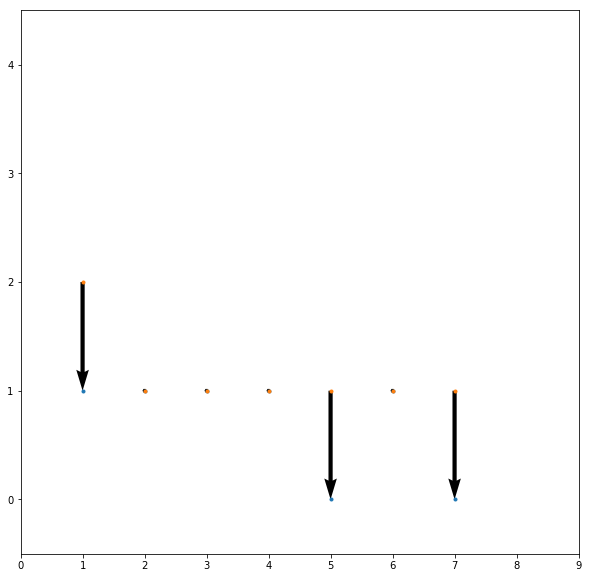

In [11]:
graph.quiver_snodes()

# Replay schedule

In [12]:
schedule_dict = graph.find_schedules()
schedule_sorted = graph.sort_schedule(schedule_dict)
for schedule in schedule_sorted:
    print(schedule)
for schedule, i_s in zip(schedule_sorted, range(len(schedule_sorted))):
    e, end_state, success = graph.simulate_transition(graph.snode_dict[0].state, graph.snode_dict[0].state, execute=False, N=10, dt=0.01, vel_conv=1e-2, err_conv=5e-4)
    timer.sleep(1)
#     try:
    e = graph.replay(schedule, execute=False, N=300, dt=0.01, N_step=10, vel_conv=1e-2, err_conv=5e-4)
#     except Exception as e:
#         print(e)

[0, 1, 2, 5]
[0, 1, 4, 7]

--------------------
1-(('box1', 'top_p', 'vac2'),)

--------------------
2-(('box1', 'left_p', 'grip1'),)

--------------------
5-(('box1', 'front_f', 'goal'),)

--------------------
1-(('box1', 'top_p', 'vac2'),)

--------------------
4-(('box1', 'right_p', 'grip1'),)

--------------------
7-(('box1', 'front_f', 'goal'),)


In [ ]:
plt.plot(e.POS)

In [ ]:
# e = graph.replay(schedule, N=1500, dt=0.002, vel_conv=1e-2, err_conv=5e-3)

In [ ]:
ctems = [gtem for gtem in GeometryItem.GLOBAL_GEO_LIST if gtem.collision]
print(len(ctems))
for ctem in ctems:
    print(ctem.name)

In [ ]:
e.displayContext()

# Test

In [ ]:
N = 300
dt = 1e-2

from_state = State((('box1','bottom_p','floor'),), {'box1': [0.5,-0.3,0.05,0,0,0,1]}, ZERO_JOINT_POSE)
to_state = State((('box1', 'top_p', 'vac2'), ),None, None)

In [ ]:
self = graph

In [ ]:
gtimer = GlobalTimer.instance()
gtimer.tic("start set transition")
if from_state is not None:
    pos_start = from_state.Q
    self.set_object_state(from_state)

tf_col_text = get_tf_collision_text(GeometryItem.GLOBAL_GEO_LIST)

In [ ]:
print(tf_col_text)

In [ ]:
N = 300
dt = 1e-2

from_state = State((('box1','bottom_p','floor'),), {'box1': [0.5,-0.3,0.05,0,0,0,1]}, ZERO_JOINT_POSE)
to_state = State((('box1', 'top_p', 'vac2'), ),None, None)


e, end_state, succ = graph.simulate_transition(from_state, to_state, display=True, print_expression=True, N=N, dt=dt, vel_conv=1e-2, err_conv=1e-3)
print(succ)
end_state_bak = end_state.copy()

In [ ]:
e.displayContext()

In [ ]:

N = 300
dt = 1e-2

from_state = end_state_bak.copy()
to_state = State((('box1', 'front_p', 'grip1'), ),None, None)


e, end_state, succ = graph.simulate_transition(from_state, to_state, display=True, print_expression=True, N=N, dt=dt, vel_conv=1e-2, err_conv=1e-3)
print(succ)
end_state_bak = end_state.copy()
N = 200
dt = 25e-3

from_state = end_state_bak.copy()
to_state = State((('box1', 'right_f', 'goal'), ),None, None)


e, end_state, succ = graph.simulate_transition(from_state, to_state, display=True, print_expression=True, N=N, dt=dt, vel_conv=1e-2, err_conv=1e-3)
print(succ)

# Visualize

In [ ]:
from pkg.graph_visualize import VisualGraph

In [ ]:
g = VisualGraph()

# for node, neighbor in graph.node_dict.items(): # for visualizing all
#     g.add_node(node,neighbor) # for visualizing all

for node, neighbor in graph.valid_node_dict.items():
    g.add_node(node,neighbor) # for visualizing all

# for idx in schedule: # for visualizing schedule
#     snode = graph.snode_vec[idx]
#     leafs = [(leaf, graph.snode_vec[leaf]) for leaf in snode.leafs if leaf in schedule] # for visualizing schedule
#     g.add_node("%d-"%idx+str(snode.state.node),["%d-"%i_l+str(leaf.state.node) for i_l, leaf in leafs]) # for visualizing schedule

In [ ]:
g.draw().render()
g.draw(True)

# delete all

In [ ]:
for mkr in marker_list:
    mkr.delete()

# Plotting (using the Bokeh library to provide interactive plots)

In [ ]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.layouts import gridplot
from etasl_py.bokehplots import plotv

output_notebook()
print("positions : ")
plotv(e.TIME,e.POS,e.POS_LBL)
print("velocities : ")
plotv(e.TIME,e.VEL,e.POS_LBL)
print("outputs : ")
plotv(e.TIME,e.OUTP,e.OUTP_LBL)

In [ ]:
!urdf_to_graphiz $(rospack find etasl_py_examples)/robots/ur10_robot.urdf
from graphviz import Source
Source.from_file('ur10.gv')